# Boosting Homework 
***
**Name**: $<$Cory Mosiman$>$ 
***

This assignment is due on Moodle by **5pm on Friday April 13th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***



In this homework you'll implement the AdaBoost classification framework to do handwritten digit recognition. Your implementation should be based on the description of AdaBoost given in the lecture slides.

<br>

![digits](mnist.png "mnist data")


<br>

Here are the rules: 

- Do **NOT** use sklearn's implementation of Adaboost.  You may however use sklearn's implementation of decisions trees. 
- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone 
import matplotlib.pylab as plt
import matplotlib.colors
%matplotlib inline 

### [5 points] Problem 1
***

Since we'll be working with binary classifiers, we'll look at the subset of the MNIST data pertaining to handwritten three's and eights. Note that we'll also be using a lower-res version of the MNIST data used in the KNN homework. The class below will load, parse, and store the subset of the. Load the data and then report: 

- The number of examples in the training set 
- The number of examples in the validation set 
- The number of pixels in each image. 

In [2]:
class ThreesAndEights:
    """
    Class to store MNIST data
    """

    def __init__(self, location):

        import pickle, gzip

        # Load the dataset
        f = gzip.open(location, 'rb')

        # Split the data set 
        X_train, y_train, X_valid, y_valid = pickle.load(f)

        # Extract only 3's and 8's for training set 
        self.X_train = X_train[np.logical_or( y_train==3, y_train == 8), :]
        self.y_train = y_train[np.logical_or( y_train==3, y_train == 8)]
        self.y_train = np.array([1 if y == 8 else -1 for y in self.y_train])
        
        # Shuffle the training data 
        shuff = np.arange(self.X_train.shape[0])
#         print(shuff, type(shuff), shuff.shape)
        np.random.shuffle(shuff)
        self.X_train = self.X_train[shuff,:]
        self.y_train = self.y_train[shuff]

        # Extract only 3's and 8's for validation set 
        self.X_valid = X_valid[np.logical_or( y_valid==3, y_valid == 8), :]
        self.y_valid = y_valid[np.logical_or( y_valid==3, y_valid == 8)]
        self.y_valid = np.array([1 if y == 8 else -1 for y in self.y_valid])
        
        f.close()

In [3]:
data = ThreesAndEights("../data/mnist21x21_3789.pklz")

In [4]:
print('There are {} examples in the training set'.format(data.X_train.shape[0]))
print('There are {} examples in the validation set'.format(data.X_valid.shape[0]))
print('There are {} pixels in the image, i.e. {} x {} pixels'.format(data.X_valid.shape[1],
                                                        np.sqrt(data.X_valid.shape[1]), 
                                                        np.sqrt(data.X_valid.shape[1])))

There are 2000 examples in the training set
There are 500 examples in the validation set
There are 441 pixels in the image, i.e. 21.0 x 21.0 pixels


### [20 points] Problem 2: Implementing AdaBoost  
***

We've given you a skeleton of the class `AdaBoost` below which will train a classifier based on boosted shallow decision trees as implemented by sklearn. Take a look at the class skeleton first so that you understand the underlying organization and data structures that we'll be using.  

In [45]:
class AdaBoost:
    def __init__(self, n_learners=20, max_depth=1, random_state=1234):
        """
        Create a new adaboost classifier.
        
        Args:
            N (int, optional): Number of weak learners in classifier.
            base (BaseEstimator, optional): Your general weak learner 
            random_state (int, optional): set random generator.  needed for unit testing. 

        Attributes:
            base (estimator): Your general weak learner 
            n_learners (int): Number of weak learners in classifier.
            alpha (ndarray): Coefficients on weak learners. 
            learners (list): List of weak learner instances. 
        """
        
        np.random.seed(random_state)
        
        self.n_learners = n_learners 
        self.base = DecisionTreeClassifier(max_depth=max_depth)
        self.alpha = np.zeros(self.n_learners)
        self.learners = []
        self.scores = []
        
    def fit(self, X_train, y_train):
        """
        Train AdaBoost classifier on data. Sets alphas and learners. 
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """
        
        for learner in range(self.n_learners):
            if learner == 0:
                w = np.ones(len(y_train))/len(y_train)
            
            # Create a new weak learner
            h = clone(self.base)
            
            # Fit weak learner using full training set and weights
            h.fit(X_train, y_train, sample_weight=w)
            
            # Extract predicted values and compare to true values
            predicted = h.predict(X_train)
            incorrect = predicted != y_train
            
            # Calculate the weighted error and alpha
            err_k = sum(incorrect*w)/sum(w)
            alpha_k = 0.5*np.log((1-err_k)/err_k)
            
            # Update w vector and normalize
            w = w*np.exp(-alpha_k*predicted*y_train)
            w = w/(sum(w))
            
            # Append weak learner to list of weak learners
            self.learners.append(h)
            
            # Append alpha to alphas array
            self.alpha[learner] = alpha_k
        
    def predict(self, X, learning = False, margins = False):
        """
        Adaboost prediction for new data X.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns: 
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """
        # List for storing alpha-weighted predictions
        y_hats = []
        
        if not learning:
            learners = self.learners
        else:
            learners = learning
            
        # iterate over all learners and create alpha-weighted predictions
        for learner in range(len(learners)):
            y_hat = learners[learner].predict(X)
            alpha_y_hat = self.alpha[learner]*y_hat
            y_hats.append(alpha_y_hat)
        
        # Transform into np array
        y_hats = np.array(y_hats)
        
        # Perform element-wise sum (i.e. for each training example)
        # of alpha-weighted predictions
        if not margins:
            y_hats = np.sum(y_hats, axis=0)
            
        # Determine sign of summed predictions and assign class
        y_hats = np.where(y_hats>0, 1, -1)
        return y_hats
    
    def score(self, X, y, learning = False):

        """
        Computes prediction accuracy of classifier.  
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            Prediction accuracy (between 0.0 and 1.0).
        """
        
        return sum(self.predict(X, learning) == y)/len(y)
        
    
    def staged_score(self, X, y, learning = False):
        """
        Computes the ensemble score after each iteration of boosting 
        for monitoring purposes, such as to determine the score on a 
        test set after each boost.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            scores (ndarary): [n_learners] ndarray of scores 
        """
        if not learning:
            learners = self.learners
        else:
            learners = learning
        scores = np.zeros_like(learners)
        for learner in range(len(learners)):
            scores[learner] = self.score(X, y, learners[0:learner+1])
        return scores

    def staged_margin(self, x, y):
        """
        Computes the staged margin after each iteration of boosting 
        for a single training example x and true label y
        
        Args:
            x (ndarray): [n_features] ndarray of data 
            y (integer): an integer {-1,1} representing the true label of x 
            
        Returns: 
            margins (ndarary): [n_learners] ndarray of margins 
        """
        margins = np.zeros_like(self.learners)
        for learner in range(len(self.learners)):
            alphas = self.alpha[0:learner+1]
            alpha_hat = alphas/sum(alphas)
            predictions = self.predict(x, learning = self.learners[0:learner+1], margins = True)
            correct = predictions == y
            incorrect = predictions != y
            margins[learner] = sum(alphas.reshape(-1,1)[correct]) - sum(alphas.reshape(-1,1)[incorrect])
       
        return margins
        
        
        

In [ ]:
n_learners=50
a = AdaBoost(n_learners=n_learners)
a.fit(data.X_train, data.y_train)
margins = a.staged_margin(data.X_valid[0].reshape(-1,441), data.y_valid[0])

Recall that the model we attempt to learn in AdaBoost is given by 

$$
H({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^K\alpha_k h_k({\bf x}) \right]
$$

where $h_k({\bf x})$ is the $k^\textrm{th}$ weak learner and $\alpha_k$ is it's associated ensemble coefficient.  

**Part A**: Implement the `fit` method to learn the sequence of weak learners $\left\{h_k({\bf x})\right\}_{k=1}^K$ and corresponding coefficients $\left\{ \alpha_k\right\}_{k=1}^K$. Note that you may use sklearn's implementation of DecisionTreeClassifier as your weak learner which allows you to pass as an optional parameter the weights associated with each training example.  An example of instantiating and training a single learner is given in the comments of the `fit` method.  

When you think you're done, run the following unit tests which corresponds to the AdaBoost example given in the lecture slides. 


In [46]:
%run -i tests.py "part A"

test_alphas (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


**Part B**: After your `fit` method is working properly, implement the `predict` method to make predictions for unseen examples stored in a data matrix ${\bf X}$.  

**Note**: Remember that AdaBoost assumes that your predictions are of the form $y \in \{-1, 1\}$. 

When you think you're done, run the following unit tests which corresponds to the AdaBoost example given in the lecture slides. 

In [47]:
%run -i tests.py "part B"

test_prediction (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


**Part C**: Next, implement the `score` method which takes in a matrix of examples ${\bf X}$ and their associated true labels ${\bf y}$, makes predictions, and returns the classification accuracy.   

When you think you're done, run the following unit tests. 

In [48]:
%run -i tests.py "part C"

test_score (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.007s

OK


**Part D**: Finally, implement the `staged_score` method to return an array of prediction accuracies after each iteration of the AdaBoost algorithm.  That is, the staged score array ${\bf s}$ is defined such that ${\bf s}_\ell$ is the prediction accuracy using only the first $\ell$ weak learners.  This function is primarily used as a diagnostic tool for analyzing the performance of your classifier during the training process.  

**Note**: This method can be implemented in a very efficient or very **in**efficient matter.  Be sure to think about this a bit before diving in. 


When you think you're done, run the following unit tests. 

In [49]:
%run -i tests.py "part D"

test_staged_score (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.008s

OK


### [10 points] Problem 3: AdaBoost for Handwritten Digit Recognition 
***

Use your AdaBoost code with Sklearn's DecisionTreeClassifier as the base learner to distinguish $3$'s from $8$'s. 
Run $n=500$ boosting iterations with trees of depths 1, 2, and 3 (go deeper if you like) as the weak learner. For each weak learner, plot the training and validation error per boosting iteration (on the same set of axes). Compare and contrast the different weak learners. Which works the best? Do you see signs of overfitting? Do any of classifiers achieve nearly 100% accuracy on the training data? What happens to the accuracy on the validation data on further iterations?

In [ ]:
depths = [1,2,3]

training_acc = {}
validation_acc = {}
n_learners = 500
for depth in depths:
    validation_scores = []
    a = AdaBoost(n_learners=n_learners, max_depth=depth)
    a.fit(data.X_train, data.y_train)
    training_acc[depth] = a.staged_score(data.X_train, data.y_train)
    validation_acc[depth] = a.staged_score(data.X_valid, data.y_valid)
    print('Completed depth: {}'.format(depth))

In [ ]:
learner_array = np.arange(1,n_learners+1)
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(15,5))
training_labels = ['Depth: ' + str(key) + ' Training' for key in training_acc.keys()]
testing_labels = ['Depth: ' + str(key) + ' Validation' for key in training_acc.keys()]
labels = training_labels + testing_labels

ax.plot(learner_array, training_acc[1], color="green", alpha = 0.5)
ax.plot(learner_array, training_acc[2], color = "dodgerblue", alpha = 0.5)
ax.plot(learner_array, training_acc[3], color = "dimgray", alpha = 0.5)

ax.plot(learner_array, validation_acc[1], color="green")
ax.plot(learner_array, validation_acc[2], color = "dodgerblue")
ax.plot(learner_array, validation_acc[3], color = "dimgray")

ax.set_xlabel('Number of Learners', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.legend(labels)
ax.grid(alpha=0.25)

**Answer:**  
For all three weak learners, the training accuracy reaches 100%, although it happens in less than 50 learners for trees of depth 2 and 3, and not until about 250 learners for depth 1.  On all sets, there are continual improvements on the testing set much after the training set has reached 100% accuracy, one of the interesting characteristics of boosted trees.  Trees of depth 2 have the highest accuracy on the validation data, reaching just over 98% accuracy.  While the accuracy of the models seems to plateau at a certain point, there is no point at which overfitting occurs as model complexity increases.

### [15 points] Problem 4: AdaBoost as a Margin-Maximizing Model 
***

Despite the fact that we're making our model more complex with the addition of each weak learner, AdaBoost does not typically overfit the training data. The reason for this is that the model becomes more _confident_ with each boosting iteration. This _confidence_ can be interpreted mathematically as a margin. Recall that after $K$ iterations the algorithm terminates with the classifier 

$$
H({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^K\alpha_k h_k({\bf x}) \right]
$$

Similarly, we can define the intermediate classifier $H_\ell$ by 

$$
H_\ell({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^\ell\alpha_k h_k({\bf x}) \right]
$$

where $\ell \leq K$. Note that in either case the model returns predictions of the form $y \in \{-1, 1\}$ which does not give us any indication of the model's confidence in a prediction. Define the normalized coefficients $\hat{\alpha}_k$ as follows: 

$$
\hat{\alpha}_k = \dfrac{\alpha_k}{\sum_{t=1}^K \alpha_k}
$$

Define the margin of a training example ${\bf x}$ after $\ell$ iterations as the sum of the normalized coefficients of weak learners that vote correctly minus the sum of the normalized coefficients of the weak learners that vote incorrectly: 

$$
\textrm{margin}_\ell ({\bf x}) = \sum_{k=1:~h_k({\bf x}) = y}^\ell \hat{\alpha}_k - \sum_{k=1:~h_k({\bf x}) \neq y}^\ell \hat{\alpha}_k 
$$

**Part A**: Briefly explain mathematically how $\textrm{margin}_\ell({\bf x})$ can be interpreted as a margin.  **Hint**: You'll want to think back on what we meant by a _margin_ in our discussion of Support Vector Machines. 

**Answer:**  
In SVMs, the margin is a measure of the distance from the decision hyperplane to a point on either side of the hyperplane.  The points defining the margin are the support vectors, and these points are the ones we are least confident about.  As the distance of a point from this hyperplane increases, our confidence in the correct classification of that point increases.  

In this context, $\textrm{margin}_\ell({\bf x})$, the value of the normalized coefficient for each learner is large if that learner was a good learner, and small if the learner was a bad learner.  Thinking about a two learner boosted model: 


| learner | $\alpha$   | $x_{correct}$   | margin |
|---------|------------|---------------|--------|
| [1,2]   | [0.1, 0.9] | [True, True]  | 1      |
| [1,2]   | [0.1, 0.9] | [True, False] | -0.8   |
| [1,2]   | [0.1, 0.9] | [False, True] | 0.8    |
| [1,2]   | [0.1, 0.9] | [False, False | -1     |

We can see that $\alpha_2$ is a strong learner and $\alpha_1$ is a weak learner.  If our weak learner makes an incorrect classification, but our strong learner makes a correct classification, the margin is still large and positive, i.e. we are still overall confident that this was a correct classification.  A large positive margin means we are very confident in the correct classification of the data point, whereas a large negative margin means we are not confident in the correct classification of the data point.

**Part B**: Complete the `staged_margin` method in the `AdaBoost` class above so that it computes the margin for a single training example ${\bf x}$ after each boosting iteration. 

**ANSWER:**  
See function

**Part C**: Find four **training** examples from the MNIST that meet the following criteria: 

- one $3$ that AdaBoost can classify easily  
- one $8$ that AdaBoost can classify easily  
- one $3$ that AdaBoost has difficulty with 
- one $8$ that AdaBoost has difficulty with 

Use the `view_digit` function given below to display the four examples that you found. 

**Advice**: Since AdaBoost will likely classify **all** training examples correctly given enough boosting iterations, you might try fitting an AdaBoost classifier with just a handful of boosting iterations and use it to identify examples of each desired type. 

In [10]:
n_learners=50
max_depth = 1
a = AdaBoost(n_learners=n_learners, max_depth=max_depth)
a.fit(data.X_train, data.y_train)

In [11]:
margins = np.zeros((data.X_valid.shape[0], n_learners))

# extract the margins for each data point over all boosting iterations
for point in range(len(data.X_valid)):
    margins[point] = a.staged_margin(data.X_valid[point].reshape(-1,441), data.y_valid[point])

In [12]:
# spearate threes and eights from validation data
x_threes = data.X_valid[data.y_valid == -1]
y_threes = data.y_valid[data.y_valid == -1]

x_eights = data.X_valid[data.y_valid == 1]
y_eights = data.y_valid[data.y_valid == 1]

# separate threes and eights in margins
three_margins = margins[data.y_valid == -1]
eight_margins = margins[data.y_valid == 1]

# Sum the margins over all learners and select the best and worst for each class
three_worst_index = np.argmin(np.sum(three_margins, axis = 1))
three_best_index = np.argmax(np.sum(three_margins, axis = 1))
eight_worst_index = np.argmin(np.sum(eight_margins, axis = 1))
eight_best_index = np.argmax(np.sum(eight_margins, axis = 1))

In [13]:
def view_digit(example, label=None):
    if label: print("true label: {:d}".format(label))
    plt.imshow(example.reshape(21,21), cmap='gray');

true label: -1


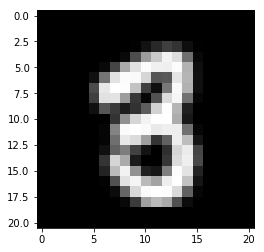

In [14]:
# Minimum margin on 3 classifier
view_digit(x_threes[three_worst_index,:], y_threes[three_worst_index])

true label: -1


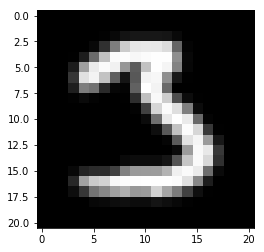

In [15]:
# Maximum margin on 3 classifier
view_digit(x_threes[three_best_index,:], y_threes[three_best_index])

true label: 1


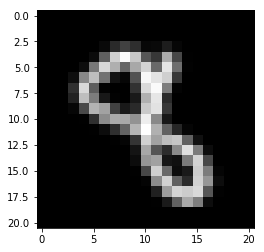

In [16]:
# Minimum margin on 8 classifier
view_digit(x_eights[eight_worst_index,:], y_eights[eight_worst_index])

true label: 1


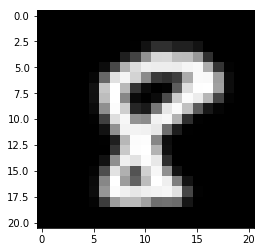

In [17]:
# Maximum margin on 8 classifier
view_digit(x_eights[eight_best_index,:], y_eights[eight_best_index])

**Part D**: Using an AdaBoost classifier with at least $K=200$ depth-1 decision trees as the weak learners, plot the staged margin for each of the four examples that you found in **Part C** on the same set of axes. (Be sure to include a legend so we can tell which staged margin corresponds to which example).  Explain your results in terms of the margin of the classifier on each training examples.  More broadly, how the margin-maximizing property might allow AdaBoost to continue improving generalization even after the error on the training set reaches zero.  


In [18]:
learners = 200
new_booster = AdaBoost(n_learners=learners)
new_booster.fit(data.X_train, data.y_train)

In [19]:
margins = np.zeros((data.X_valid.shape[0], learners))

# extract the margins for each data point over all boosting iterations
for point in range(len(data.X_valid)):
    margins[point] = new_booster.staged_margin(data.X_valid[point].reshape(-1,441), data.y_valid[point])

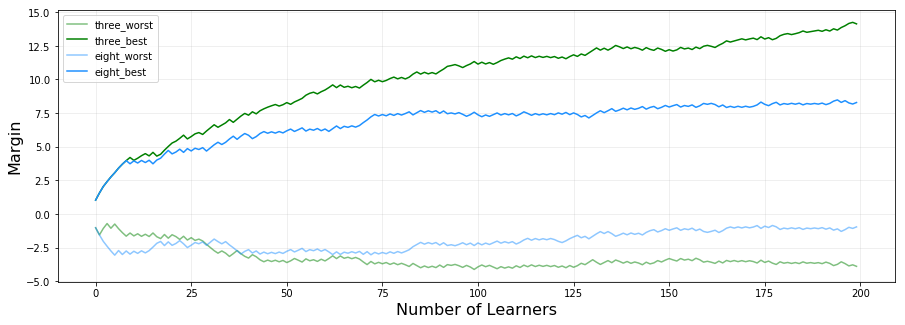

In [44]:
# separate margins by classes (threes and eights)
three_margins = margins[data.y_valid == -1]
eight_margins = margins[data.y_valid == 1]

# Create array for x axis
x = np.arange(0,learners)
labels = ['three_worst', 'three_best', 'eight_worst', 'eight_best']

# keep indices from previous problem and plot
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize = (15,5))
ax.plot(x, three_margins[three_worst_index], color="green", alpha = 0.5)
ax.plot(x, three_margins[three_best_index], color="green")
ax.plot(x, eight_margins[eight_worst_index], color="dodgerblue", alpha = 0.5)
ax.plot(x, eight_margins[eight_best_index], color="dodgerblue")
ax.set_xlabel('Number of Learners', fontsize=16)
ax.set_ylabel('Margin', fontsize=16)
ax.legend(labels)
ax.grid(alpha=0.25)

Explain your results in terms of the margin of the classifier on each training examples.  More broadly, how the margin-maximizing property might allow AdaBoost to continue improving generalization even after the error on the training set reaches zero.

**Answer:**  
We can see that for the two training examples that the algorithm performed poorly on, while the margin decreases semi-quickly at first, actually begins to increase again near n_learners = 100 and stay semi stagnant.  The margin maximizing characteristic basically ensures that the algorithm will always be trying to increase the overall confidence for every training example, and not learning just to minimize the number of misclassifications overall.